# Autoencoders with Keras and Tensorflow <a class="tocSkip">

[Tomas Beuzen](https://tomasbeuzen.github.io/) (April 2020)
    
---    

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports</a></span></li></ul></li><li><span><a href="#Example-1:-dimensionality-reduction" data-toc-modified-id="Example-1:-dimensionality-reduction-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Example 1: dimensionality reduction</a></span><ul class="toc-item"><li><span><a href="#Create-some-synthetic-data" data-toc-modified-id="Create-some-synthetic-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Create some synthetic data</a></span></li><li><span><a href="#Build-an-autoencoder" data-toc-modified-id="Build-an-autoencoder-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Build an autoencoder</a></span></li><li><span><a href="#Test-the-autoencoder" data-toc-modified-id="Test-the-autoencoder-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Test the autoencoder</a></span></li></ul></li><li><span><a href="#Example-2:-image-reproduction" data-toc-modified-id="Example-2:-image-reproduction-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Example 2: image reproduction</a></span><ul class="toc-item"><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Load the data</a></span></li><li><span><a href="#Build-an-autoencoder" data-toc-modified-id="Build-an-autoencoder-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Build an autoencoder</a></span></li><li><span><a href="#Test-the-autoencoder" data-toc-modified-id="Test-the-autoencoder-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Test the autoencoder</a></span></li></ul></li><li><span><a href="#Example-3:-image-denoising" data-toc-modified-id="Example-3:-image-denoising-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Example 3: image denoising</a></span><ul class="toc-item"><li><span><a href="#Making-the-data-noisey" data-toc-modified-id="Making-the-data-noisey-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Making the data noisey</a></span></li><li><span><a href="#Build-an-autoencoder" data-toc-modified-id="Build-an-autoencoder-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Build an autoencoder</a></span></li><li><span><a href="#Test-the-autoencoder" data-toc-modified-id="Test-the-autoencoder-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Test the autoencoder</a></span></li></ul></li></ul></div>

# Introduction

- Autoencoders are actually fairly simple networks that are designed to reproduce their input at the output layer, i.e., input neurons = output neurons
- The hidden layers of the network are typically smaller than the input/output layers, i.e., autoencoders reduce the dimensionality of the data as it is passed through the network
- You can read more about autoencoders here:
    - [Building autoencoders in Keras, blog.keras.io](https://blog.keras.io/building-autoencoders-in-keras.html)

<img src="https://miro.medium.com/max/1400/1*oUbsOnYKX5DEpMOK3pH_lg.png" alt="Drawing" style="width: 500px;"/>

Source: [medium.com](https://miro.medium.com/max/1400/1*oUbsOnYKX5DEpMOK3pH_lg.png)

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import axes3d
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, GaussianNoise
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16,
                     'axes.labelweight': 'bold',
                     'figure.figsize': (8,6)})

# Example 1: dimensionality reduction

## Create some synthetic data

- As you might have guessed, if we just consider the encoder part of an autoencoder, we can use it for dimensionality reduction
- In this way, autoencoders can be useful for:
    - compressing data
    - visualizing in lower dimensions
    - exploring higher dimensional relationships
- Let's see an example, below we will generate some synthetic data with 3 feature and 2 classes

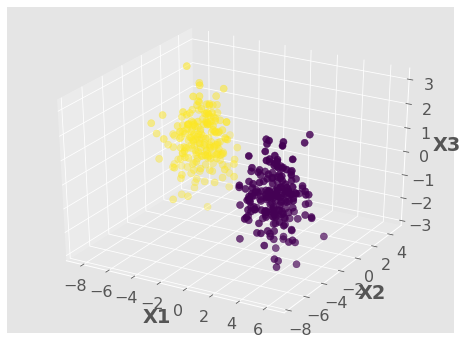

In [2]:
X12,y = make_blobs(n_samples=400,
                   n_features=2,
                   centers=2,
                   cluster_std=1,
                   random_state=123)
np.random.seed(1)
X = pd.DataFrame({'X1': X12[:,0],
                  'X2': X12[:,1],
                  'X3': np.random.normal(size=len(X12))})
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'})
ax.scatter(X['X1'], X['X2'], X['X3'], c=y, s=50)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3');

- Let's plot the data
- You can see that `X1` and `X2` split the data nicely, but `X3` (the noise feature) isn't informative for separating the classed
- Hint: You can type `%matplotlib notebook` to make the figure interactive

## Build an autoencoder

- Our aim is to see if we can reduce our data to two dimensions (we actually know that there only two helpful features here...)
- So we'll build an autoencoder that goes from 3 neurons --> 2 neurons --> 3 neurons

In [3]:
# first the encoder
encoder = Sequential()
encoder.add(Dense(units=2, activation='relu', input_shape=[3]))
# now the decoder
decoder = Sequential()
decoder.add(Dense(units=3, activation='relu', input_shape=[2]))

In [4]:
# now combine the encoder + decoder into the autoencoder
autoencoder = Sequential([encoder,
                          decoder])
autoencoder.compile(loss='mse', optimizer='adam')

In [5]:
# before we train, let's scale our data (there's no train/test split here, so scale everything)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
# now fit the model (remember we want our input data and output data to be the same,
# so we pass X_scaled as both the input and the output in fit())
autoencoder.fit(X_scaled, X_scaled, epochs=5);

Train on 400 samples
Epoch 1/5
400/400 [==============================] - 0s 1ms/sample - loss: 0.2639
Epoch 2/5
400/400 [==============================] - 0s 34us/sample - loss: 0.2488
Epoch 3/5
400/400 [==============================] - 0s 36us/sample - loss: 0.2352
Epoch 4/5
400/400 [==============================] - 0s 39us/sample - loss: 0.2080
Epoch 5/5
400/400 [==============================] - 0s 40us/sample - loss: 0.1788


## Test the autoencoder

- Now that we've trained our model, let's just use the encoder to transform ("predict") our input data
- Essentially, we want to see the two-dimensional version of our three-dimensional dataset
- We will then plot the data to see how well our reduceded dimensionality represents our data

In [7]:
print(f"Original X shape = {X.shape}")
X_encoded = encoder.predict(X_scaled)
print(f" Encoded X shape = {X_encoded.shape}")

Original X shape = (400, 3)
 Encoded X shape = (400, 2)


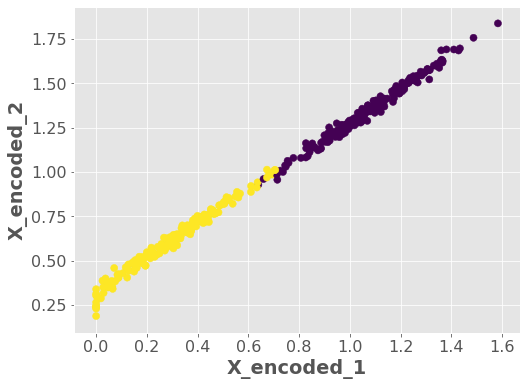

In [8]:
fig, ax = plt.subplots(1, 1)
ax.scatter(X_encoded[:,0], X_encoded[:,1], c=y, s=50)
ax.set_xlabel('X_encoded_1')
ax.set_ylabel('X_encoded_2');

- So we can see that our data is still clearly separable, even though we've reduced it down to two dimensions, cool!
- We've successfully reduced the dimensionality of our dataset
- This technique is obviously useful for reducing the dimensionality of high dimensional datasets and for visualizing high dimensional data
- In the next section we'll work with some common high-dimensional data: Images!

# Example 2: image reproduction

- As we saw in the previous section, we can reduce the dimensionality of our dataset using autoencoders
- Images have a lot of features (pixels)
- It would be useful if we could represent an entire image with just a few transformed features
- We'll be trying this out with the MNIST digits dataset here
- We'll be checking that an AE can actually reduce and then reproduce an image

## Load the data

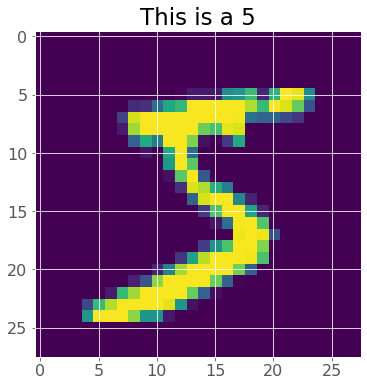

In [9]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
plt.imshow(X_train[0])
plt.title(f"This is a {y_train[0]}");

In [10]:
# scale the data
X_train = X_train / 255
X_test = X_test / 255

## Build an autoencoder

- We have 784 pixels in each image (28 * 28)
- Let's build a "stacked AE", reducing the dimensionality by about half each layer
- Jumping straight from 784 to something like 25 might be too big of a jump

In [11]:
# first build the encoder
encoder = Sequential()
encoder.add(Flatten(input_shape=[28, 28]))
encoder.add(Dense(400, activation='relu'))
encoder.add(Dense(200, activation='relu'))
encoder.add(Dense(100, activation='relu'))
encoder.add(Dense(50, activation='relu'))
encoder.add(Dense(25, activation='relu'))

# decoder mirrors the encoder
decoder = Sequential()
decoder.add(Dense(50, input_shape=[25], activation='relu'))
decoder.add(Dense(100, activation='relu'))
decoder.add(Dense(200, activation='relu'))
decoder.add(Dense(400, activation='relu'))
decoder.add(Dense(28*28, activation='sigmoid'))
decoder.add(Reshape([28, 28]))

In [1]:
# now the autoencoder, I'll train with just 5 epoch
autoencoder = Sequential([encoder,
                          decoder])
autoencoder.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])
autoencoder.fit(X_train, X_train, epochs=5);

NameError: name 'Sequential' is not defined

## Test the autoencoder

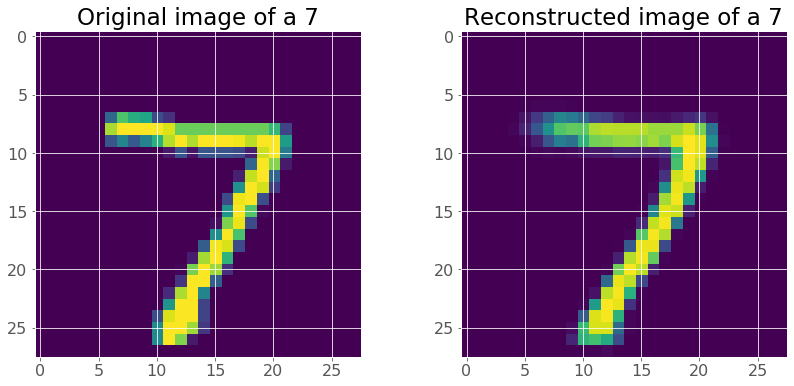

In [13]:
passed_images = autoencoder.predict(X_test[:1])
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].imshow(X_test[0])
ax[0].set_title(f"Original image of a {y_test[0]}")
ax[1].imshow(passed_images[0])
ax[1].set_title(f"Reconstructed image of a {y_test[0]}");

- Looks like our AE can reconstruct input images, nice!
- This is actually quite impressive! We reduced our dimensionality down from 784 to 25, and then re-built our image from just 25 dimensions
- This means that it is able to reduce the input features to a significantly reduced dimensionality, but which still contains enough information to rebuild the image
- In the next section we'll look at a more practical example of using an AE to de-noise an image - we've just shown that an AE can learn the important information of an image, can it learn the not important information?

# Example 3: image denoising

- In this section we will build on the previous example to see if an AE can be useful for denoising images
- We are going to artifically add some noise to our MNIST digits and see if we can use an AE to remove it

## Making the data noisey

In [14]:
# dont worry about the warning when running this cell
sample = GaussianNoise(0.2)
noisey_images = sample(X_test[:10], training=True)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



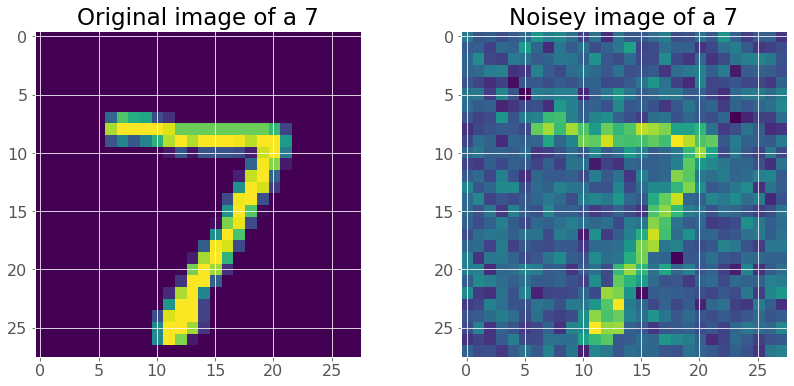

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].imshow(X_test[0])
ax[0].set_title(f"Original image of a {y_test[0]}")
ax[1].imshow(noisey_images[0])
ax[1].set_title(f"Noisey image of a {y_test[0]}");

## Build an autoencoder

In [16]:
# first build the encoder
encoder = Sequential()
encoder.add(Flatten(input_shape=[28, 28]))
encoder.add(GaussianNoise(0.2))  # <- add Gaussian noise
encoder.add(Dense(400, activation='relu'))
encoder.add(Dense(200, activation='relu'))
encoder.add(Dense(100, activation='relu'))
encoder.add(Dense(50, activation='relu'))
encoder.add(Dense(25, activation='relu'))

# decoder mirrors the encoder
decoder = Sequential()
decoder.add(Dense(50, input_shape=[25], activation='relu'))
decoder.add(Dense(100, activation='relu'))
decoder.add(Dense(200, activation='relu'))
decoder.add(Dense(400, activation='relu'))
decoder.add(Dense(28*28, activation='sigmoid'))
decoder.add(Reshape([28, 28]))

In [17]:
autoencoder = Sequential([encoder,
                          decoder])
autoencoder.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])
autoencoder.fit(X_train, X_train, epochs=5);

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 11s 191us/sample - loss: 0.1749 - accuracy: 0.7999
Epoch 2/5
60000/60000 [==============================] - 11s 176us/sample - loss: 0.1334 - accuracy: 0.8072
Epoch 3/5
60000/60000 [==============================] - 11s 183us/sample - loss: 0.1224 - accuracy: 0.8092
Epoch 4/5
60000/60000 [==============================] - 11s 178us/sample - loss: 0.1174 - accuracy: 0.8101
Epoch 5/5
60000/60000 [==============================] - 11s 187us/sample - loss: 0.1141 - accuracy: 0.8107


## Test the autoencoder

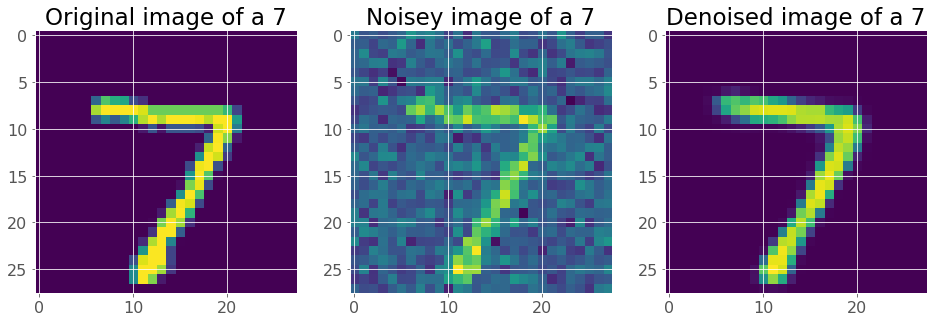

In [18]:
denoised_images = autoencoder.predict(noisey_images[:1])
fig, ax = plt.subplots(1, 3, figsize=(16, 6))
ax[0].imshow(X_test[0])
ax[0].set_title(f"Original image of a {y_test[0]}")
ax[1].imshow(noisey_images[0])
ax[1].set_title(f"Noisey image of a {y_test[0]}")
ax[2].imshow(denoised_images[0])
ax[2].set_title(f"Denoised image of a {y_test[0]}");

- Awesome! So we trained an AE to learn the important information in an image and remove the non-important noise
- In the next [tutorial](variational_autoencoders.ipynb), we'll look at leveraging an AE to actually generate completely new, synthetic images